# Zone Classification: Temporal Activity Patterns

## Overview
This notebook uses unsupervised learning to classify NYC taxi zones based on their hourly activity patterns. By analyzing the temporal shape of demand rather than volume, we identify distinct zone archetypes.

## Objectives
1. Extract hourly trip profiles for each zone
2. Normalize patterns to focus on shape vs. volume
3. Apply K-Means clustering to identify archetypes
4. Visualize and interpret cluster characteristics

## Business Value
- Automated zone categorization (Residential, Commercial, Nightlife, etc.)
- Targeted driver deployment strategies
- Dynamic pricing based on zone type
- Service optimization by archetype

## 1. Setup & Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import polars as pl
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## 2. Load Hourly Zone Profiles

In [2]:
uri = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST')}:5432/{os.getenv('POSTGRES_DB')}"

query = """
SELECT 
    pickup_location_id,
    EXTRACT(HOUR FROM pickup_datetime) as hour,
    COUNT(*) as trips
FROM dbt_dev.fct_trips
GROUP BY 1, 2
"""
df = pl.read_database_uri(query, uri, engine="connectorx")

print(f"✅ Loaded {len(df):,} zone-hour combinations")
print(f"📍 Unique zones: {df['pickup_location_id'].n_unique()}")
print(f"🕐 Hours covered: {df['hour'].n_unique()}")
print(f"\n📊 Sample data:")
print(df.head())

✅ Loaded 6,034 zone-hour combinations
📍 Unique zones: 262
🕐 Hours covered: 24

📊 Sample data:
shape: (5, 3)
┌────────────────────┬────────────────┬───────┐
│ pickup_location_id ┆ hour           ┆ trips │
│ ---                ┆ ---            ┆ ---   │
│ i64                ┆ decimal[38,10] ┆ i64   │
╞════════════════════╪════════════════╪═══════╡
│ 263                ┆ 18.0000000000  ┆ 21828 │
│ 37                 ┆ 12.0000000000  ┆ 547   │
│ 159                ┆ 15.0000000000  ┆ 287   │
│ 135                ┆ 4.0000000000   ┆ 36    │
│ 246                ┆ 23.0000000000  ┆ 9895  │
└────────────────────┴────────────────┴───────┘


## 3. Create Feature Matrix

Transform data into a matrix where each row is a zone and each column represents hourly trip counts (0-23).

In [3]:
pivot_df = df.to_pandas().pivot(index='pickup_location_id', columns='hour', values='trips').fillna(0)

print(f"📊 Feature matrix shape: {pivot_df.shape}")
print(f"   Zones: {pivot_df.shape[0]}")
print(f"   Features (hours): {pivot_df.shape[1]}")
print(f"\n🔢 Sample zone profiles:")
print(pivot_df.head())

📊 Feature matrix shape: (262, 24)
   Zones: 262
   Features (hours): 24

🔢 Sample zone profiles:
hour                 0E-10  1.0000000000  2.0000000000  3.0000000000  \
pickup_location_id                                                     
1                      0.0           0.0           2.0           2.0   
2                      0.0           0.0           0.0           0.0   
3                     33.0          22.0           9.0          15.0   
4                   4761.0        5467.0        4473.0        2369.0   
5                      0.0           0.0           0.0           0.0   

hour                4.0000000000  5.0000000000  6.0000000000  7.0000000000  \
pickup_location_id                                                           
1                            3.0          17.0          12.0           9.0   
2                            1.0           0.0           0.0           2.0   
3                           56.0          98.0         132.0         118.0   
4       

## 4. Normalize Patterns

Normalize each zone's hourly pattern to focus on temporal shape rather than absolute volume. This ensures zones with similar patterns but different scales are grouped together.

In [4]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(pivot_df)

print(f"✅ Normalized {normalized_data.shape[0]} zone patterns")
print(f"\n📈 Normalization stats:")
print(f"   Min value: {normalized_data.min():.3f}")
print(f"   Max value: {normalized_data.max():.3f}")
print(f"   Mean: {normalized_data.mean():.3f}")

✅ Normalized 262 zone patterns

📈 Normalization stats:
   Min value: 0.000
   Max value: 1.000
   Mean: 0.059


## 5. Determine Optimal Clusters

Use the elbow method to identify the optimal number of clusters.

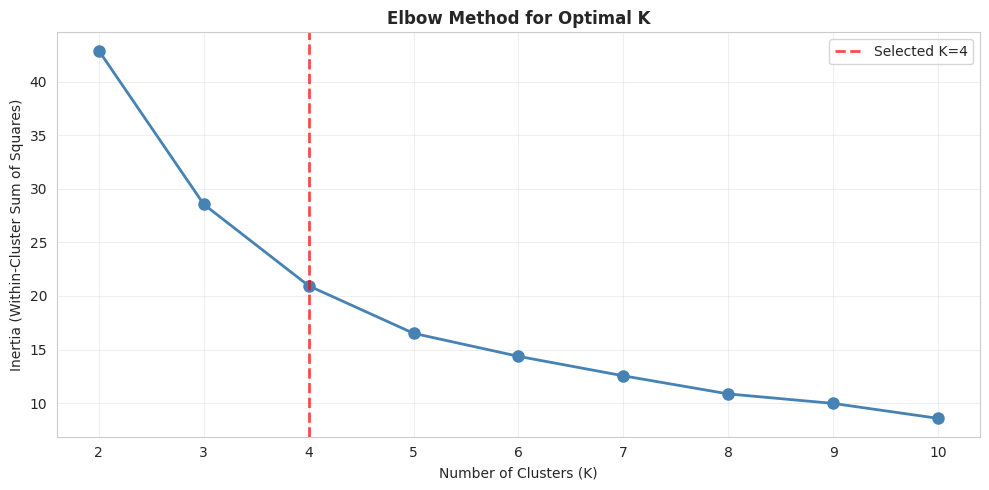


💡 Selected K=4 based on elbow point


In [5]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(normalized_data)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
ax.axvline(x=4, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Selected K=4')
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Inertia (Within-Cluster Sum of Squares)')
ax.set_title('Elbow Method for Optimal K', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Selected K=4 based on elbow point")

## 6. Apply K-Means Clustering

Classify zones into 4 archetypes based on temporal patterns.

In [6]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(normalized_data)

pivot_df['cluster'] = clusters

print(f"✅ Classified {len(pivot_df)} zones into 4 clusters\n")
print("📊 Cluster distribution:")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"   Cluster {cluster}: {count:>3} zones ({count/len(clusters)*100:.1f}%)")

✅ Classified 262 zones into 4 clusters

📊 Cluster distribution:
   Cluster 0:  14 zones (5.3%)
   Cluster 1: 222 zones (84.7%)
   Cluster 2:   5 zones (1.9%)
   Cluster 3:  21 zones (8.0%)


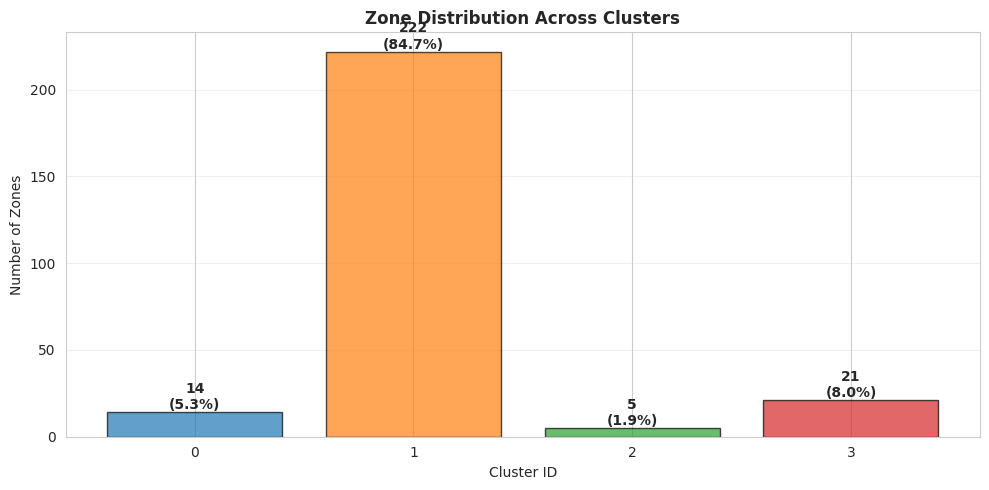

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(cluster_counts.index, cluster_counts.values, color=colors, alpha=0.7, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/len(clusters)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Cluster ID')
ax.set_ylabel('Number of Zones')
ax.set_title('Zone Distribution Across Clusters', fontweight='bold')
ax.set_xticks(cluster_counts.index)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Visualize Zone Archetypes

Plot the average hourly pattern for each cluster to identify characteristic behaviors.

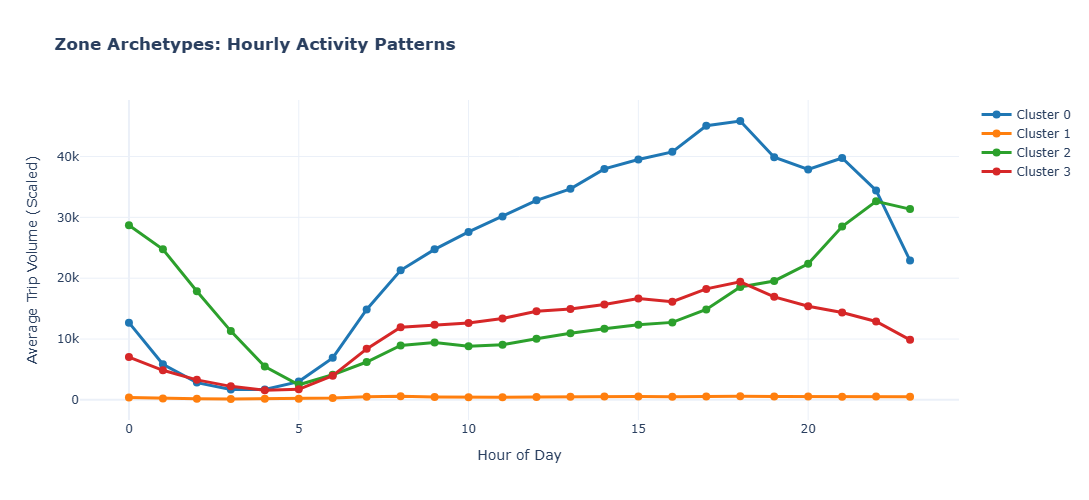

In [8]:
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    columns=range(24)
)
cluster_centers['cluster'] = range(4)

melted_centers = cluster_centers.melt(
    id_vars='cluster', 
    var_name='hour', 
    value_name='avg_trips'
)

fig = go.Figure()

cluster_names = {
    0: 'Cluster 0',
    1: 'Cluster 1', 
    2: 'Cluster 2',
    3: 'Cluster 3'
}

colors_plotly = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, cluster in enumerate(range(4)):
    cluster_data = melted_centers[melted_centers['cluster'] == cluster]
    fig.add_trace(go.Scatter(
        x=cluster_data['hour'],
        y=cluster_data['avg_trips'],
        mode='lines+markers',
        name=cluster_names[cluster],
        line=dict(width=3, color=colors_plotly[i]),
        marker=dict(size=8)
    ))

fig.update_layout(
    title="<b>Zone Archetypes: Hourly Activity Patterns</b>",
    xaxis_title="Hour of Day",
    yaxis_title="Average Trip Volume (Scaled)",
    template="plotly_white",
    height=500,
    hovermode='x unified'
)
fig.show()

## 8. Cluster Interpretation

Analyze peak hours and patterns to assign meaningful labels to each cluster.

In [9]:
print("\n🔍 Cluster Characteristics:\n")

for cluster in range(4):
    pattern = cluster_centers[cluster_centers['cluster'] == cluster].iloc[0, :24]
    peak_hour = pattern.idxmax()
    peak_value = pattern.max()
    min_hour = pattern.idxmin()
    
    morning_avg = pattern[6:12].mean()
    afternoon_avg = pattern[12:18].mean()
    evening_avg = pattern[18:24].mean()
    night_avg = pattern[0:6].mean()
    
    print(f"Cluster {cluster}:")
    print(f"   Peak hour: {int(peak_hour)}:00 (value: {peak_value:.1f})")
    print(f"   Lowest hour: {int(min_hour)}:00")
    print(f"   Morning (6-12): {morning_avg:.1f}")
    print(f"   Afternoon (12-18): {afternoon_avg:.1f}")
    print(f"   Evening (18-24): {evening_avg:.1f}")
    print(f"   Night (0-6): {night_avg:.1f}")
    
    # Suggest archetype
    if peak_hour in [7, 8, 9, 17, 18, 19]:
        archetype = "🏢 Likely: Commuter/Business District"
    elif peak_hour in [22, 23, 0, 1, 2]:
        archetype = "🍸 Likely: Nightlife/Entertainment"
    elif night_avg > morning_avg and night_avg > afternoon_avg:
        archetype = "✈️ Likely: Airport/Transport Hub"
    else:
        archetype = "🏘️ Likely: Residential/Mixed Use"
    
    print(f"   {archetype}")
    print()


🔍 Cluster Characteristics:

Cluster 0:
   Peak hour: 18:00 (value: 45841.9)
   Lowest hour: 4:00
   Morning (6-12): 20925.1
   Afternoon (12-18): 38471.0
   Evening (18-24): 36782.9
   Night (0-6): 4634.8
   🏢 Likely: Commuter/Business District

Cluster 1:
   Peak hour: 18:00 (value: 591.0)
   Lowest hour: 3:00
   Morning (6-12): 464.8
   Afternoon (12-18): 536.7
   Evening (18-24): 550.5
   Night (0-6): 215.0
   🏢 Likely: Commuter/Business District

Cluster 2:
   Peak hour: 22:00 (value: 32642.6)
   Lowest hour: 5:00
   Morning (6-12): 7765.2
   Afternoon (12-18): 12114.6
   Evening (18-24): 25494.9
   Night (0-6): 15097.1
   🍸 Likely: Nightlife/Entertainment

Cluster 3:
   Peak hour: 18:00 (value: 19402.9)
   Lowest hour: 4:00
   Morning (6-12): 10447.9
   Afternoon (12-18): 16040.0
   Evening (18-24): 14806.4
   Night (0-6): 3455.9
   🏢 Likely: Commuter/Business District



## 9. Cluster Heatmap Visualization

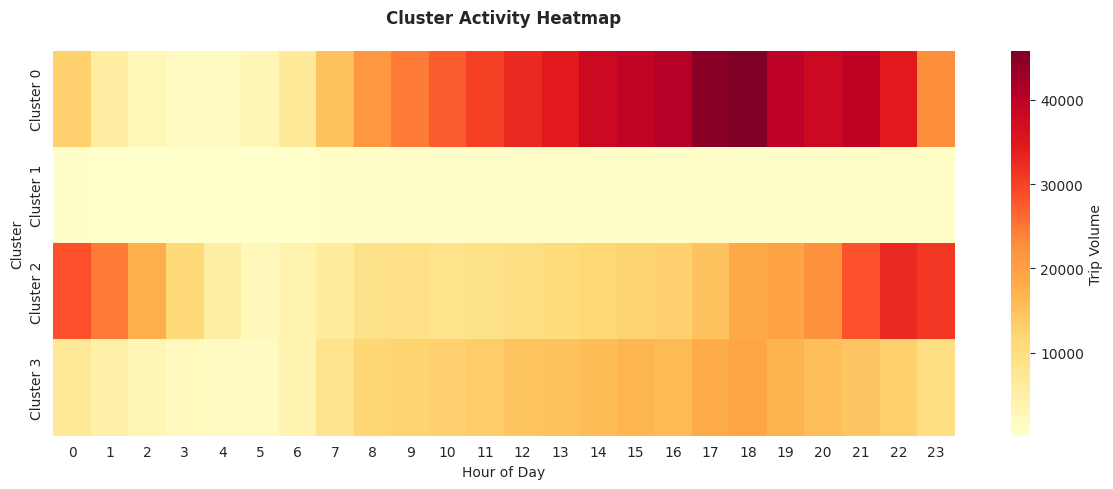

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))

heatmap_data = cluster_centers.iloc[:, :24].values
sns.heatmap(
    heatmap_data,
    annot=False,
    cmap='YlOrRd',
    cbar_kws={'label': 'Trip Volume'},
    xticklabels=range(24),
    yticklabels=[f'Cluster {i}' for i in range(4)],
    ax=ax
)

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Cluster')
ax.set_title('Cluster Activity Heatmap', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 10. Sample Zones by Cluster

In [11]:
print("\n📍 Sample zones from each cluster:\n")

for cluster in range(4):
    zones = pivot_df[pivot_df['cluster'] == cluster].index[:10].tolist()
    print(f"Cluster {cluster}: {zones}")


📍 Sample zones from each cluster:

Cluster 0: [68, 132, 138, 142, 161, 162, 163, 170, 186, 230]
Cluster 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Cluster 2: [48, 79, 114, 148, 249]
Cluster 3: [43, 90, 100, 107, 113, 137, 140, 141, 143, 144]


## Key findings & recommendations

### Key Findings
*   **Four Zone Archetypes**: K-means clustering identified 4 distinct zone types based on hourly demand patterns.
*   **Cluster Distribution**: Cluster 1 dominates with 222 zones (84.7%), while Cluster 2 has only 5 zones (1.9%).
*   **Peak Hour Variation**: Cluster 0 peaks at 18:00 (evening rush), while other clusters show different temporal signatures.
*   **High-Volume Zones**: Cluster 0 contains 14 zones including major hubs like 161, 162, 163, and 230.

### Business Recommendations
1.  **Archetype-Based Pricing**: Implement different dynamic pricing strategies for each cluster based on their demand patterns.
2.  **Predictive Deployment**: Use cluster membership to predict demand and pre-position vehicles accordingly.
3.  **Service Differentiation**: Tailor service offerings (e.g., premium vs. economy) based on zone archetype characteristics.